In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import csv

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import resample

In [2]:
!python -V

Python 3.7.11


In [3]:
tf.__version__

'2.1.0'

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #print no of GPU device

Num GPUs Available:  1


# Prepare Data 

In [5]:
ROOT = 'Breast scans'
train_path_benign = ROOT + '/benign/train'
train_path_malignant = ROOT + '/malignant/train'
train_path_normal = ROOT + '/normal/train'

test_path_benign = ROOT + '/benign/test'
test_path_malignant = ROOT + '/malignant/test'
test_path_normal = ROOT + '/normal/test'

In [6]:
# Create a list to hold image details
image_list = []
normal_train = []
benign_train = []
malignant_train = []
normal_test = []
benign_test = []
malignant_test = []


for root_folder, sub_folder, filenames in os.walk(train_path_benign):
    for filename in filenames:
        if filename.endswith('.png'):
            image_list.append([filename, 'benign', 'train'])
            if filename.find('mask') < 0:
                benign_train.append(train_path_benign + '/' + filename)

for root_folder, sub_folder, filenames in os.walk(train_path_malignant):
    for filename in filenames:
        if filename.endswith('.png'):
            image_list.append([filename, 'malignant', 'train'])
            if filename.find('mask') < 0:
                malignant_train.append(train_path_malignant + '/' + filename)

for root_folder, sub_folder, filenames in os.walk(train_path_normal):
    for filename in filenames:
        if filename.endswith('.png'):
            image_list.append([filename, 'normal', 'train'])
            if filename.find('mask') < 0:
                normal_train.append(train_path_normal + '/' + filename)

for root_folder, sub_folder, filenames in os.walk(test_path_benign):
    for filename in filenames:
        if filename.endswith('.png'):
            image_list.append([filename, 'benign', 'test'])
            if filename.find('mask') < 0:
                benign_test.append(test_path_benign + '/' + filename)

for root_folder, sub_folder, filenames in os.walk(test_path_malignant):
    for filename in filenames:
        if filename.endswith('.png'):
            image_list.append([filename, 'malignant', 'test'])
            if filename.find('mask') < 0:
                malignant_test.append(test_path_malignant + '/' + filename)

for root_folder, sub_folder, filenames in os.walk(test_path_normal):
    for filename in filenames:
        if filename.endswith('.png'):
            image_list.append([filename, 'normal', 'test'])
            if filename.find('mask') < 0:
                normal_test.append(test_path_normal + '/' + filename)


In [7]:
# Write the image details to a CSV file
with open('image_details.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Filename', 'Class', 'Type'])
    writer.writerows(image_list)

In [8]:
df = pd.read_csv('image_details.csv')
df

,Filename,Class,Type
0,benign (1).png,benign,train
1,benign (1)_mask.png,benign,train
2,benign (10).png,benign,train
3,benign (10)_mask.png,benign,train
4,benign (100).png,benign,train
...,...,...,...
1439,normal (129).png,normal,test
1440,normal (130).png,normal,test
1441,normal (131).png,normal,test
1442,normal (132).png,normal,test


In [9]:
df = df[~df['Filename'].str.contains('mask')]
df

,Filename,Class,Type
0,benign (1).png,benign,train
2,benign (10).png,benign,train
4,benign (100).png,benign,train
7,benign (101).png,benign,train
9,benign (102).png,benign,train
...,...,...,...
1439,normal (129).png,normal,test
1440,normal (130).png,normal,test
1441,normal (131).png,normal,test
1442,normal (132).png,normal,test


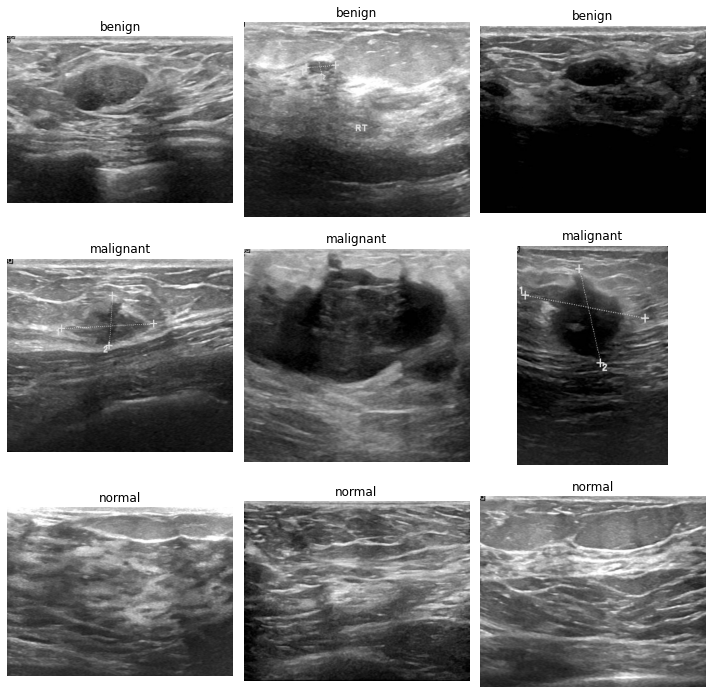

In [10]:
ROOT = 'Breast scans'
classes = ["benign", "malignant", "normal"]
num_images = 3

fig, axes = plt.subplots(len(classes), num_images, figsize=(10,10))

for i, cls in enumerate(classes):
    cls_folder = os.path.join(ROOT, cls, "train")
    images = os.listdir(cls_folder)
    images = [img for img in images if "mask" not in img]  # exclude images with "mask" in their name
    images = random.sample(images, num_images)
    for j, image_name in enumerate(images):
        image_path = os.path.join(cls_folder, image_name)
        image = plt.imread(image_path)
        axes[i, j].imshow(image)
        axes[i, j].set_title(cls)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


Size not same!

In [11]:
class_counts = df.groupby(['Class', 'Type']).size().reset_index(name='Count')
class_counts = class_counts.sort_values(by=['Type', 'Class'], ascending=[False, True])
class_counts

,Class,Type,Count
1,benign,train,397
3,malignant,train,180
5,normal,train,103
0,benign,test,40
2,malignant,test,30
4,normal,test,30


"Data imbalance" is normal in medical images and is acceptable during model training. Based on the final results, we will decide whether we need to balance the data or not. 

### Balance Data

In [12]:
malignant_train = resample(malignant_train,
                                 replace=True,     
                                 n_samples=len(benign_train))
normal_train = resample(normal_train, 
                                 replace=True,   
                                 n_samples=len(benign_train))

In [13]:
## after upsampling
print("Breast - Normal: ",len(normal_train))
print("Breast - Benign: ",len(benign_train))
print("Breast - Malignant: ",len(malignant_train))

Breast - Normal:  397
Breast - Benign:  397
Breast - Malignant:  397


In [14]:
len(malignant_train)

397

# Preprocessing

### Imbanace Data

In [15]:
ROOT = 'Breast scans'

class_labels = [("benign", 0), ("malignant", 1), ("normal", 2)]

train_data = []
test_data = []

for class_name, class_label in class_labels:
    for split in ["train", "test"]:
        split_folder = os.path.join(ROOT, class_name, split)
        file_names = os.listdir(split_folder)
        for file_name in file_names:
            file_path = os.path.join(split_folder, file_name)
            if file_name.find('mask') < 0:
                if split == "train":
                    train_data.append((file_path, class_label, "train"))
                else:
                    test_data.append((file_path, class_label, "test"))

# Create pandas DataFrames for train and test data
train_df_Im = pd.DataFrame(train_data, columns=["file_path", "label", "split"])
train_df_Im["label"] = train_df_Im["label"].astype(str)
test_df_Im = pd.DataFrame(test_data, columns=["file_path", "label", "split"])
test_df_Im["label"] = test_df_Im["label"].astype(str)
train_df_Im

,file_path,label,split
0,Breast scans\benign\train\benign (1).png,0,train
1,Breast scans\benign\train\benign (10).png,0,train
2,Breast scans\benign\train\benign (100).png,0,train
3,Breast scans\benign\train\benign (101).png,0,train
4,Breast scans\benign\train\benign (102).png,0,train
...,...,...,...
675,Breast scans\normal\train\normal (95).png,2,train
676,Breast scans\normal\train\normal (96).png,2,train
677,Breast scans\normal\train\normal (97).png,2,train
678,Breast scans\normal\train\normal (98).png,2,train


### Balanced Data

In [16]:
ROOT = 'Breast scans'

# Create a list of tuples with class names and corresponding label indices
class_labels = [("benign", 0), ("malignant", 1), ("normal", 2)]

train_data = []
test_data = []

for item in benign_train:
    train_data.append((item, 0, "train"))

for item in malignant_train:
    train_data.append((item, 1, "train"))

for item in normal_train:
    train_data.append((item, 2, "train"))

# Loop through classes and splits to get image file paths and labels
for class_name, class_label in class_labels:
    for split in ["train", "test"]:
        split_folder = os.path.join(ROOT, class_name, split)
        file_names = os.listdir(split_folder)
        for file_name in file_names:
            file_path = os.path.join(split_folder, file_name)
            if file_name.find('mask') < 0:
                if split == "test":
                    test_data.append((file_path, class_label, "train"))

# Create pandas DataFrames for train and test data
train_df = pd.DataFrame(train_data, columns=["file_path", "label", "split"])
train_df["label"] = train_df["label"].astype(str)
test_df = pd.DataFrame(test_data, columns=["file_path", "label", "split"])
test_df["label"] = test_df["label"].astype(str)
train_df


,file_path,label,split
0,Breast scans/benign/train/benign (1).png,0,train
1,Breast scans/benign/train/benign (10).png,0,train
2,Breast scans/benign/train/benign (100).png,0,train
3,Breast scans/benign/train/benign (101).png,0,train
4,Breast scans/benign/train/benign (102).png,0,train
...,...,...,...
1186,Breast scans/normal/train/normal (11).png,2,train
1187,Breast scans/normal/train/normal (65).png,2,train
1188,Breast scans/normal/train/normal (94).png,2,train
1189,Breast scans/normal/train/normal (82).png,2,train


In [17]:
# Define the list of classes
classes = ["benign", "malignant", "normal"]

# Define the image size
img_size = (256, 256)

# Define the batch size
batch_size = 32

### Data Augmentation for imbalanced data

In [18]:
# Define the data generator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True
    )

testgen = ImageDataGenerator(
    rescale=1./255)

In [19]:
# Create train and test data generators using flow_from_dataframe
train_generator_Im = datagen.flow_from_dataframe(
    dataframe=train_df_Im,
    x_col="file_path",
    y_col="label",
    subset="training",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical")

test_generator_Im = testgen.flow_from_dataframe(
    dataframe=test_df_Im,
    x_col="file_path",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical")


Found 680 validated image filenames belonging to 3 classes.
Found 100 validated image filenames belonging to 3 classes.


### Data Augmentation for balanced data

In [20]:
# Create train and test data generators using flow_from_dataframe
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file_path",
    y_col="label",
    subset="training",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical")

test_generator = testgen.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_path",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical")


Found 1191 validated image filenames belonging to 3 classes.
Found 100 validated image filenames belonging to 3 classes.


# Model

In [21]:
lr = 1e-5

# Imbalanced Data

# VGG16

In [22]:
#load pre-trained VGG16 model without top layers
model_VGG16_Im = Sequential()
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[0], 3))
for layer in base_model.layers:
  layer.traiable = False
model_VGG16_Im.add(base_model)
model_VGG16_Im.add(Flatten())
model_VGG16_Im.add(Dense(512,activation='relu'))
model_VGG16_Im.add(BatchNormalization())
model_VGG16_Im.add(Dense(256,activation='relu'))
model_VGG16_Im.add(BatchNormalization())
model_VGG16_Im.add(Dense(128,activation='relu'))
model_VGG16_Im.add(BatchNormalization())
model_VGG16_Im.add(Dense(3, activation="softmax"))
model_VGG16_Im.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 3 steps
Epoch 1/25
20/21 [===========================>..] - ETA: 1s - loss: 1.3232 - accuracy: 0.4302
Epoch 00001: val_loss improved from inf to 1.07023, saving model to model_VGG16_Im.h5
21/21 [==============================] - 27s 1s/step - loss: 1.3303 - accuracy: 0.4275 - val_loss: 1.0702 - val_accuracy: 0.5208
Epoch 2/25
20/21 [===========================>..] - ETA: 0s - loss: 1.0559 - accuracy: 0.5568
Epoch 00002: val_loss improved from 1.07023 to 1.05225, saving model to model_VGG16_Im.h5
21/21 [==============================] - 18s 859ms/step - loss: 1.0487 - accuracy: 0.5586 - val_loss: 1.0523 - val_accuracy: 0.4792
Epoch 3/25
20/21 [===========================>..] - ETA: 0s - loss: 0.8827 - accuracy: 0.6282
Epoch 00003: val_loss improved from 1.05225 to 1.01582, saving model to model_VGG16_Im.h5
21/21 [==============================] - 18s 881ms/step - loss: 0.8845 - accuracy: 0.6296 - val_loss

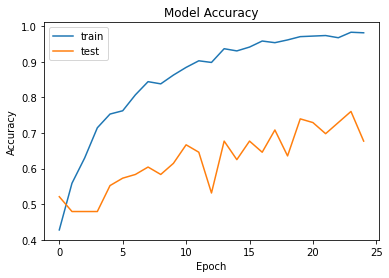

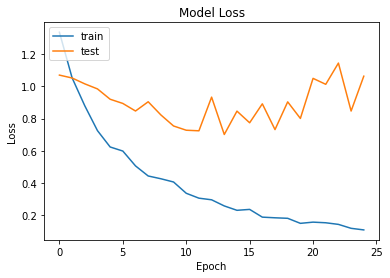

In [23]:
#compile the model
model_VGG16_Im.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint('model_VGG16_Im.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train the model
history = model_VGG16_Im.fit(train_generator_Im,steps_per_epoch=len(train_df_Im) // batch_size,validation_steps=len(test_df_Im) // batch_size, validation_data=test_generator, epochs=25, callbacks=[checkpoint_callback])

# plot accuracy and loss curves
plt.plot(model_VGG16_Im.history.history['accuracy'])
plt.plot(model_VGG16_Im.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_VGG16_Im.history.history['loss'])
plt.plot(model_VGG16_Im.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# make predictions on test data
predictions = model_VGG16_Im.predict(test_generator_Im)

### Evaluate Model

In [24]:
# evaluate the model on the test set
test_loss, test_accuracy = model_VGG16_Im.evaluate(test_generator)

# print the test accuracy
print('Test accuracy:', test_accuracy)

  ...
    to  
  ['...']
4/4 [==============================] - 3s 748ms/step - loss: 0.8908 - accuracy: 0.6800
Test accuracy: 0.68


# ResNet50

In [22]:
#load pre-trained ResNet50 model without top layers
model_ResNet50_Im = Sequential()
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[0], 3))
for layer in base_model.layers:
  layer.traiable = False
model_ResNet50_Im.add(base_model)
model_ResNet50_Im.add(Flatten())
model_ResNet50_Im.add(Dense(512,activation='relu'))
model_ResNet50_Im.add(BatchNormalization())
model_ResNet50_Im.add(Dense(256,activation='relu'))
model_ResNet50_Im.add(BatchNormalization())
model_ResNet50_Im.add(Dense(128,activation='relu'))
model_ResNet50_Im.add(BatchNormalization())
model_ResNet50_Im.add(Dense(3, activation="softmax"))
model_ResNet50_Im.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 3 steps
Epoch 1/25
20/21 [===========================>..] - ETA: 1s - loss: 1.4766 - accuracy: 0.4026
Epoch 00001: val_loss improved from inf to 1.40016, saving model to model_ResNet50_Im.h5
21/21 [==============================] - 33s 2s/step - loss: 1.4657 - accuracy: 0.4105 - val_loss: 1.4002 - val_accuracy: 0.2917
Epoch 2/25
20/21 [===========================>..] - ETA: 0s - loss: 1.0779 - accuracy: 0.5438
Epoch 00002: val_loss improved from 1.40016 to 1.21894, saving model to model_ResNet50_Im.h5
21/21 [==============================] - 19s 925ms/step - loss: 1.0756 - accuracy: 0.5478 - val_loss: 1.2189 - val_accuracy: 0.3021
Epoch 3/25
20/21 [===========================>..] - ETA: 0s - loss: 0.9352 - accuracy: 0.6153
Epoch 00003: val_loss did not improve from 1.21894
21/21 [==============================] - 16s 784ms/step - loss: 0.9414 - accuracy: 0.6065 - val_loss: 1.3761 - val_accuracy: 0.3021
E

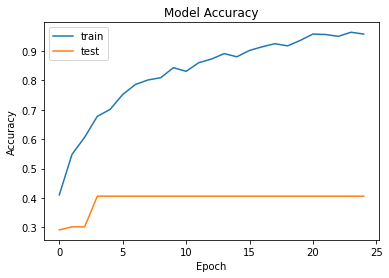

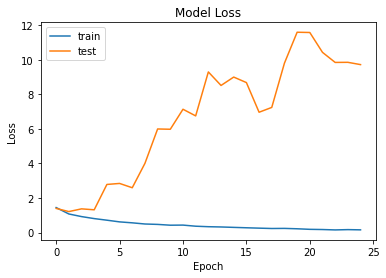

In [23]:
#compile the model
model_ResNet50_Im.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint('model_ResNet50_Im.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train the model
history = model_ResNet50_Im.fit(train_generator_Im,steps_per_epoch=len(train_df_Im) // batch_size,validation_steps=len(test_df_Im) // batch_size, validation_data=test_generator, epochs=25, callbacks=[checkpoint_callback])

# plot accuracy and loss curves
plt.plot(model_ResNet50_Im.history.history['accuracy'])
plt.plot(model_ResNet50_Im.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_ResNet50_Im.history.history['loss'])
plt.plot(model_ResNet50_Im.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# make predictions on test data
predictions = model_ResNet50_Im.predict(test_generator_Im)

### Evaluate Model

In [24]:
# evaluate the model on the test set
test_loss, test_accuracy = model_ResNet50_Im.evaluate(test_generator)

# print the test accuracy
print('Test accuracy:', test_accuracy)

  ...
    to  
  ['...']
4/4 [==============================] - 1s 288ms/step - loss: 10.4592 - accuracy: 0.4000
Test accuracy: 0.4


# MobileNetV2

In [25]:
#load pre-trained MobileNetV2 model without top layers
model_MobileNetV2_Im = Sequential()
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[0], 3))
for layer in base_model.layers:
  layer.traiable = False
model_MobileNetV2_Im.add(base_model)
model_MobileNetV2_Im.add(Flatten())
model_MobileNetV2_Im.add(Dense(512,activation='relu'))
model_MobileNetV2_Im.add(BatchNormalization())
model_MobileNetV2_Im.add(Dense(256,activation='relu'))
model_MobileNetV2_Im.add(BatchNormalization())
model_MobileNetV2_Im.add(Dense(128,activation='relu'))
model_MobileNetV2_Im.add(BatchNormalization())
model_MobileNetV2_Im.add(Dense(3, activation="softmax"))
model_MobileNetV2_Im.summary()

c:\Users\AhmedRabie\.conda\envs\Py37GPU\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               41943552  
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 3 steps
Epoch 1/25
20/21 [===========================>..] - ETA: 1s - loss: 1.4864 - accuracy: 0.3458
Epoch 00001: val_loss improved from inf to 1.35638, saving model to model_MobileNetV2_Im.h5
21/21 [==============================] - 28s 1s/step - loss: 1.4788 - accuracy: 0.3519 - val_loss: 1.3564 - val_accuracy: 0.3229
Epoch 2/25
20/21 [===========================>..] - ETA: 0s - loss: 1.2684 - accuracy: 0.4464
Epoch 00002: val_loss did not improve from 1.35638
21/21 [==============================] - 16s 778ms/step - loss: 1.2677 - accuracy: 0.4429 - val_loss: 1.4009 - val_accuracy: 0.3333
Epoch 3/25
20/21 [===========================>..] - ETA: 0s - loss: 1.1395 - accuracy: 0.5081
Epoch 00003: val_loss did not improve from 1.35638
21/21 [==============================] - 17s 790ms/step - loss: 1.1350 - accuracy: 0.5123 - val_loss: 1.5287 - val_accuracy: 0.3333
Epoch 4/25
20/21 [======================

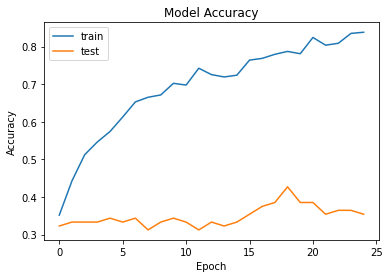

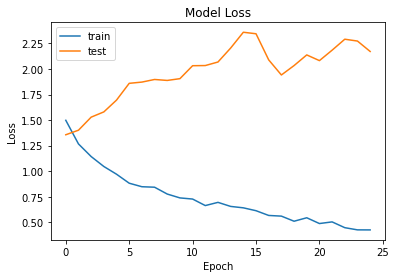

In [26]:
#compile the model
model_MobileNetV2_Im.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint('model_MobileNetV2_Im.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train the model
history = model_MobileNetV2_Im.fit(train_generator_Im,steps_per_epoch=len(train_df_Im) // batch_size,validation_steps=len(test_df_Im) // batch_size, validation_data=test_generator, epochs=25, callbacks=[checkpoint_callback])

# plot accuracy and loss curves
plt.plot(model_MobileNetV2_Im.history.history['accuracy'])
plt.plot(model_MobileNetV2_Im.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_MobileNetV2_Im.history.history['loss'])
plt.plot(model_MobileNetV2_Im.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# make predictions on test data
predictions = model_MobileNetV2_Im.predict(test_generator_Im)

### Evaluate Model

In [27]:
# evaluate the model on the test set
test_loss, test_accuracy = model_MobileNetV2_Im.evaluate(test_generator)

# print the test accuracy
print('Test accuracy:', test_accuracy)

  ...
    to  
  ['...']
4/4 [==============================] - 1s 264ms/step - loss: 1.9247 - accuracy: 0.3600
Test accuracy: 0.36


# MobileNet

In [28]:
#load pre-trained MobileNet model without top layers
model_MobileNet_Im = Sequential()
base_model = MobileNet(weights='imagenet', dropout = 0.5, include_top=False, input_shape=(img_size[0], img_size[0], 3))
for layer in base_model.layers:
  layer.traiable = False
model_MobileNet_Im.add(base_model)
model_MobileNet_Im.add(Flatten())
model_MobileNet_Im.add(Dense(512,activation='relu'))
model_MobileNet_Im.add(BatchNormalization())
model_MobileNet_Im.add(Dense(256,activation='relu'))
model_MobileNet_Im.add(BatchNormalization())
model_MobileNet_Im.add(Dense(128,activation='relu'))
model_MobileNet_Im.add(BatchNormalization())
model_MobileNet_Im.add(Dense(3, activation="softmax"))
model_MobileNet_Im.summary()

c:\Users\AhmedRabie\.conda\envs\Py37GPU\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 8, 8, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               33554944  
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 3 steps
Epoch 1/25
20/21 [===========================>..] - ETA: 0s - loss: 1.4835 - accuracy: 0.3977
Epoch 00001: val_loss improved from inf to 1.29984, saving model to model_MobileNet_Im.h5
21/21 [==============================] - 24s 1s/step - loss: 1.4861 - accuracy: 0.3966 - val_loss: 1.2998 - val_accuracy: 0.3750
Epoch 2/25
20/21 [===========================>..] - ETA: 0s - loss: 1.1879 - accuracy: 0.4903
Epoch 00002: val_loss improved from 1.29984 to 1.20837, saving model to model_MobileNet_Im.h5
21/21 [==============================] - 19s 885ms/step - loss: 1.1705 - accuracy: 0.4938 - val_loss: 1.2084 - val_accuracy: 0.4375
Epoch 3/25
20/21 [===========================>..] - ETA: 0s - loss: 1.0096 - accuracy: 0.6006
Epoch 00003: val_loss improved from 1.20837 to 1.18878, saving model to model_MobileNet_Im.h5
21/21 [==============================] - 18s 855ms/step - loss: 1.0131 - accuracy: 0.598

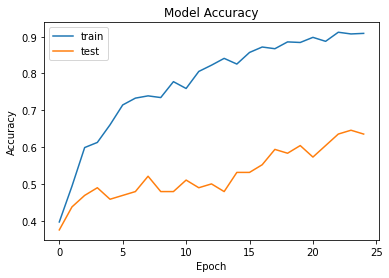

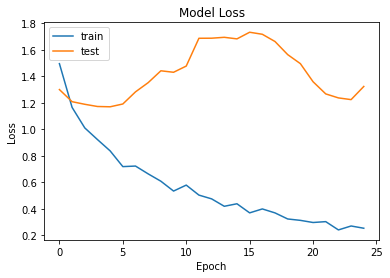

In [29]:
#compile the model
model_MobileNet_Im.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint('model_MobileNet_Im.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train the model

history = model_MobileNet_Im.fit(train_generator_Im,steps_per_epoch=len(train_df_Im) // batch_size,validation_steps=len(test_df_Im) // batch_size, validation_data=test_generator, epochs=25, callbacks=[checkpoint_callback])

# plot accuracy and loss curves
plt.plot(model_MobileNet_Im.history.history['accuracy'])
plt.plot(model_MobileNet_Im.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_MobileNet_Im.history.history['loss'])
plt.plot(model_MobileNet_Im.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# make predictions on test data
predictions = model_MobileNet_Im.predict(test_generator_Im)

### Evaluate Model

In [30]:
# evaluate the model on the test set
test_loss, test_accuracy = model_MobileNet_Im.evaluate(test_generator)

# print the test accuracy
print('Test accuracy:', test_accuracy)

  ...
    to  
  ['...']
4/4 [==============================] - 1s 282ms/step - loss: 1.0307 - accuracy: 0.6500
Test accuracy: 0.65


# Balanced Data

### VGG16

In [22]:
#load pre-trained VGG16 model without top layers
model_VGG16 = Sequential()
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[0], 3))
for layer in base_model.layers:
  layer.traiable = False
model_VGG16.add(base_model)
model_VGG16.add(Flatten())
model_VGG16.add(Dense(512,activation='relu'))
model_VGG16.add(BatchNormalization())
model_VGG16.add(Dense(256,activation='relu'))
model_VGG16.add(BatchNormalization())
model_VGG16.add(Dense(128,activation='relu'))
model_VGG16.add(BatchNormalization())
model_VGG16.add(Dense(3, activation="softmax"))
model_VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 37 steps, validate for 3 steps
Epoch 1/25
36/37 [============================>.] - ETA: 0s - loss: 1.0456 - accuracy: 0.5519
Epoch 00001: val_loss improved from inf to 1.11810, saving model to model_VGG16.h5
37/37 [==============================] - 36s 983ms/step - loss: 1.0397 - accuracy: 0.5548 - val_loss: 1.1181 - val_accuracy: 0.4271
Epoch 2/25
36/37 [============================>.] - ETA: 0s - loss: 0.6815 - accuracy: 0.7267
Epoch 00002: val_loss improved from 1.11810 to 1.00920, saving model to model_VGG16.h5
37/37 [==============================] - 30s 814ms/step - loss: 0.6799 - accuracy: 0.7282 - val_loss: 1.0092 - val_accuracy: 0.5208
Epoch 3/25
36/37 [============================>.] - ETA: 0s - loss: 0.5248 - accuracy: 0.7899
Epoch 00003: val_loss improved from 1.00920 to 0.93555, saving model to model_VGG16.h5
37/37 [==============================] - 31s 827ms/step - loss: 0.5234 - accuracy: 0.7897 - val_loss: 0.93

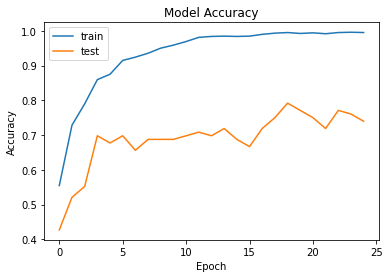

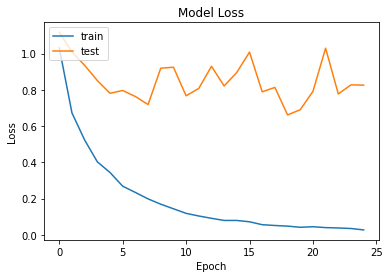

In [23]:
#compile the model
model_VGG16.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint('model_VGG16.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train the model
history = model_VGG16.fit(train_generator,steps_per_epoch=len(train_df) // batch_size,validation_steps=len(test_df) // batch_size, validation_data=test_generator, epochs=25, callbacks=[checkpoint_callback])

# plot accuracy and loss curves
plt.plot(model_VGG16.history.history['accuracy'])
plt.plot(model_VGG16.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_VGG16.history.history['loss'])
plt.plot(model_VGG16.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# make predictions on test data
predictions = model_VGG16.predict(test_generator)

### Evaluate Model

In [24]:
# evaluate the model on the test set
test_loss, test_accuracy = model_VGG16.evaluate(test_generator)

# print the test accuracy
print('Test accuracy:', test_accuracy)

  ...
    to  
  ['...']
4/4 [==============================] - 1s 310ms/step - loss: 0.9054 - accuracy: 0.7300
Test accuracy: 0.73


### ResNet50

In [22]:
#load pre-trained ResNet50 model without top layers
model_ResNet50 = Sequential()
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[0], 3))
for layer in base_model.layers:
  layer.traiable = False
model_ResNet50.add(base_model)
model_ResNet50.add(Flatten())
model_ResNet50.add(Dense(512,activation='relu'))
model_ResNet50.add(BatchNormalization())
model_ResNet50.add(Dense(256,activation='relu'))
model_ResNet50.add(BatchNormalization())
model_ResNet50.add(Dense(128,activation='relu'))
model_ResNet50.add(BatchNormalization())
model_ResNet50.add(Dense(3, activation="softmax"))
model_ResNet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 37 steps, validate for 3 steps
Epoch 1/25
36/37 [============================>.] - ETA: 1s - loss: 1.1361 - accuracy: 0.5209
Epoch 00001: val_loss improved from inf to 1.13117, saving model to model_ResNet50.h5
37/37 [==============================] - 44s 1s/step - loss: 1.1317 - accuracy: 0.5255 - val_loss: 1.1312 - val_accuracy: 0.2917
Epoch 2/25
36/37 [============================>.] - ETA: 0s - loss: 0.6616 - accuracy: 0.7300
Epoch 00002: val_loss did not improve from 1.13117
37/37 [==============================] - 29s 786ms/step - loss: 0.6834 - accuracy: 0.7274 - val_loss: 1.2329 - val_accuracy: 0.3021
Epoch 3/25
36/37 [============================>.] - ETA: 0s - loss: 0.5296 - accuracy: 0.7933
Epoch 00003: val_loss did not improve from 1.13117
37/37 [==============================] - 30s 799ms/step - loss: 0.5228 - accuracy: 0.7964 - val_loss: 1.6023 - val_accuracy: 0.3021
Epoch 4/25
36/37 [============================

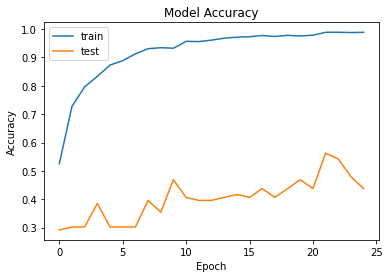

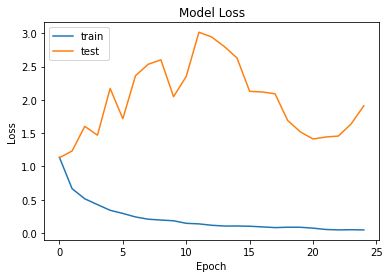

In [23]:
#compile the model
model_ResNet50.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint('model_ResNet50.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train the model
history = model_ResNet50.fit(train_generator,steps_per_epoch=len(train_df) // batch_size,validation_steps=len(test_df) // batch_size, validation_data=test_generator, epochs=25, callbacks=[checkpoint_callback])

# plot accuracy and loss curves
plt.plot(model_ResNet50.history.history['accuracy'])
plt.plot(model_ResNet50.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_ResNet50.history.history['loss'])
plt.plot(model_ResNet50.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# make predictions on test data
predictions = model_ResNet50.predict(test_generator)
Model_ResNet50 = model_ResNet50

### Evaluate Model

In [24]:
# evaluate the model on the test set
test_loss, test_accuracy = Model_ResNet50.evaluate(test_generator)

# print the test accuracy
print('Test accuracy:', test_accuracy)

  ...
    to  
  ['...']
4/4 [==============================] - 1s 289ms/step - loss: 1.6939 - accuracy: 0.4500
Test accuracy: 0.45


### MobileNetV2

In [25]:
#load pre-trained MobileNetV2 model without top layers
model_MobileNetV2 = Sequential()
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
  layer.traiable = False
model_MobileNetV2.add(base_model)
model_MobileNetV2.add(Flatten())
model_MobileNetV2.add(Dense(512,activation='relu'))
model_MobileNetV2.add(BatchNormalization())
model_MobileNetV2.add(Dense(256,activation='relu'))
model_MobileNetV2.add(BatchNormalization())
model_MobileNetV2.add(Dense(128,activation='relu'))
model_MobileNetV2.add(BatchNormalization())
model_MobileNetV2.add(Dense(3, activation="softmax"))
model_MobileNetV2.summary()

c:\Users\AhmedRabie\.conda\envs\Py37GPU\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               41943552  
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 37 steps, validate for 3 steps
Epoch 1/25
36/37 [============================>.] - ETA: 0s - loss: 1.3579 - accuracy: 0.4534
Epoch 00001: val_loss improved from inf to 1.23445, saving model to model_MobileNetV2.h5
37/37 [==============================] - 40s 1s/step - loss: 1.3479 - accuracy: 0.4573 - val_loss: 1.2345 - val_accuracy: 0.3125
Epoch 2/25
36/37 [============================>.] - ETA: 0s - loss: 0.9170 - accuracy: 0.6185
Epoch 00002: val_loss did not improve from 1.23445
37/37 [==============================] - 28s 759ms/step - loss: 0.9196 - accuracy: 0.6169 - val_loss: 1.2504 - val_accuracy: 0.3854
Epoch 3/25
36/37 [============================>.] - ETA: 0s - loss: 0.8015 - accuracy: 0.6992
Epoch 00003: val_loss did not improve from 1.23445
37/37 [==============================] - 28s 752ms/step - loss: 0.7952 - accuracy: 0.7006 - val_loss: 1.3418 - val_accuracy: 0.3854
Epoch 4/25
36/37 [=========================

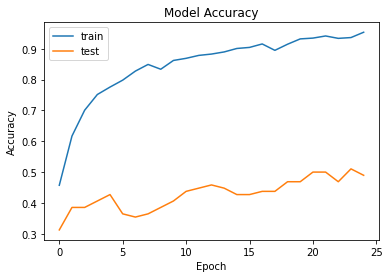

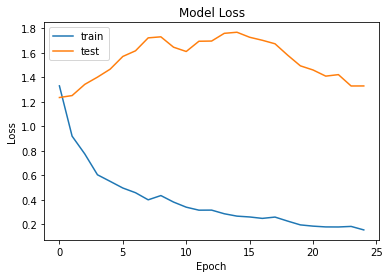

In [26]:
#compile the model
model_MobileNetV2.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint('model_MobileNetV2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train the model
history = model_MobileNetV2.fit(train_generator,steps_per_epoch=len(train_df) // batch_size,validation_steps=len(test_df) // batch_size, validation_data=test_generator, epochs=25, callbacks=[checkpoint_callback])

# plot accuracy and loss curves
plt.plot(model_MobileNetV2.history.history['accuracy'])
plt.plot(model_MobileNetV2.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_MobileNetV2.history.history['loss'])
plt.plot(model_MobileNetV2.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# make predictions on test data
predictions = model_MobileNetV2.predict(test_generator)

### Evaluate Model

In [27]:
# evaluate the model on the test set
test_loss, test_accuracy = model_MobileNetV2.evaluate(test_generator)

# print the test accuracy
print('Test accuracy:', test_accuracy)

  ...
    to  
  ['...']
4/4 [==============================] - 1s 253ms/step - loss: 1.5272 - accuracy: 0.4800
Test accuracy: 0.48


### MobileNet

In [28]:
#load pre-trained MobileNetV2 model without top layers
model_MobileNet = Sequential()
base_model = MobileNet(weights='imagenet', dropout = 0.5, include_top=False, input_shape=(img_size[0], img_size[0], 3))
for layer in base_model.layers:
  layer.traiable = False
model_MobileNet.add(base_model)
model_MobileNet.add(Flatten())
model_MobileNet.add(Dense(512,activation='relu'))
model_MobileNet.add(BatchNormalization())
model_MobileNet.add(Dense(256,activation='relu'))
model_MobileNet.add(BatchNormalization())
model_MobileNet.add(Dense(128,activation='relu'))
model_MobileNet.add(BatchNormalization())
model_MobileNet.add(Dense(3, activation="softmax"))
model_MobileNet.summary()

c:\Users\AhmedRabie\.conda\envs\Py37GPU\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 8, 8, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               33554944  
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 37 steps, validate for 3 steps
Epoch 1/25
36/37 [============================>.] - ETA: 0s - loss: 1.2710 - accuracy: 0.4694
Epoch 00001: val_loss improved from inf to 0.98125, saving model to model_MobileNet.h5
37/37 [==============================] - 35s 942ms/step - loss: 1.2589 - accuracy: 0.4737 - val_loss: 0.9813 - val_accuracy: 0.5625
Epoch 2/25
36/37 [============================>.] - ETA: 0s - loss: 0.7510 - accuracy: 0.6806
Epoch 00002: val_loss did not improve from 0.98125
37/37 [==============================] - 28s 759ms/step - loss: 0.7474 - accuracy: 0.6808 - val_loss: 1.0413 - val_accuracy: 0.5104
Epoch 3/25
36/37 [============================>.] - ETA: 0s - loss: 0.5658 - accuracy: 0.7657
Epoch 00003: val_loss did not improve from 0.98125
37/37 [==============================] - 28s 765ms/step - loss: 0.5681 - accuracy: 0.7653 - val_loss: 1.0477 - val_accuracy: 0.5729
Epoch 4/25
36/37 [========================

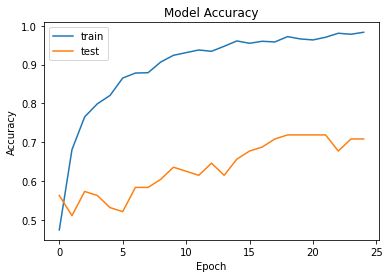

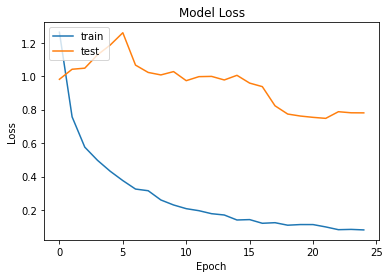

In [29]:
#compile the model
model_MobileNet.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint('model_MobileNet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train the model
history = model_MobileNet.fit(train_generator,steps_per_epoch=len(train_df) // batch_size,validation_steps=len(test_df) // batch_size, validation_data=test_generator, epochs=25, callbacks=[checkpoint_callback])

# plot accuracy and loss curves
plt.plot(model_MobileNet.history.history['accuracy'])
plt.plot(model_MobileNet.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_MobileNet.history.history['loss'])
plt.plot(model_MobileNet.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# make predictions on test data
predictions = model_MobileNet.predict(test_generator)

### Evaluate Model

In [30]:
# evaluate the model on the test set
test_loss, test_accuracy = model_MobileNet.evaluate(test_generator)

# print the test accuracy
print('Test accuracy:', test_accuracy)

  ...
    to  
  ['...']
4/4 [==============================] - 1s 253ms/step - loss: 0.7213 - accuracy: 0.7100
Test accuracy: 0.71


# Test Image for each class

In [82]:
def chs_ran_Img(dir):

    # Get a list of all image filenames in the directory
    files = os.listdir(dir)

    # Filter out any non-image files
    image_files = [f for f in files if f.endswith('.png') and 'mask' not in f]

    # Select a random image filename from the list
    random_image_filename = random.choice(image_files)

    # Get the full path to the selected image
    img_path = dir + '/' + random_image_filename

    # Now you can load or process the image using the path obtained above

    img = load_img(img_path, target_size=img_size)

    # convert to array
    img_array = img_to_array(img)

    # expand dimensions to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)

    # preprocess the image
    img_preprocessed = img_array / 255.

    pred = model_VGG16.predict(img_preprocessed)
    class_idx = np.argmax(pred[0])
    idx2label = {0: 'Benign', 1: 'Malignant', 2: 'Normal'}
    class_label = idx2label[class_idx]
    print('image Path: ' , img_path)
    print("Predicted class label: ", class_label)

In [ ]:
model_VGG16 = tf.keras.models.load_model('model_VGG16.h5')

### Benign

In [83]:
chs_ran_Img(test_path_benign)

image Path:  Breast scans/benign/test/benign (432).png
Predicted class label:  Benign


### Malignant

In [84]:
chs_ran_Img(test_path_malignant)

image Path:  Breast scans/malignant/test/malignant (203).png
Predicted class label:  Malignant


### Normal

In [86]:
chs_ran_Img(test_path_normal)

image Path:  Breast scans/normal/test/normal (118).png
Predicted class label:  Normal
